# Measurement Memory
In the optimization of the flight path, we need to compute measurements at many positions, which is expensive for the convolution type measurements. However, during the optimization's steps, especially towards the end when the algorithm converges, those measurement positions don't actually change that much. It therefore makes sense to save them instead than computing them from scratch every time.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

n_steps = 100

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.005  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 50  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

bool_transient = False  # stationary or transient model?

# what kind of measurements
which_detector = "uniform" #"truncGaussian" #"pointwise" #"truncGaussian" #"uniform" #"pointwise"

## Setup

In [3]:
# import classes according to settings

# transient or stationary model?
if bool_transient:
    from FOM import FOM as FOM
else:
    from FOM_stationary import FOM_stationary as FOM
    
# what type of measurements?
if which_detector == "pointwise":
    from DetectorPointwise import DetectorPointwise as Detector
elif which_detector == "uniform":
    from DetectorUniform import DetectorUniform as Detector
elif which_detector == "truncGaussian":
    from DetectorTruncGaussian import DetectorTruncGaussian as Detector
elif which_detector == "Gaussian":
    raise NotImplementedError("DetectorGaussian not yet supported for transient problems (need to figure out boundary conditions)")
else:
    raise RuntimeError("invalid detector class")

initializations

In [4]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = Detector(fom, meshDim=meshDim_drone, radius=radius, sigma=sigma)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

Runtime of this block: 0.38019800186157227 s


## Remembering measurements

We start off from an arbitrary state for which we want to take measurements. In the optimization, there will be one state for each parameter basis function. Here we only look at one to demonstrate.

In [5]:
para = np.ones((n_para,))

tStart = time.time()
state = fom.solve(parameter=para)
print("FOM solve time: {} s.".format(time.time()-tStart))

FOM solve time: 0.28318214416503906 s.


We choose flight path that is approximate a quarter circle, just for demonstration:

In [6]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.1]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

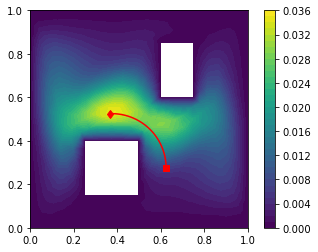

In [7]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state, time=grid_t[-1])
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

In our baseline code, a measurement along this path takes about half a second. If the same code is run again, it takes about the same time again. Obviously that's not efficient when the discretization is fine and we need to take many measurements several times in the course of the optimization.

In [8]:
# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  7.686768054962158 s.
measurement time (run 2):  0.0016968250274658203 s.


After the first, longer computation, all following measurements for the same flight path should be very fast. More than that, if we evaluate on a flightpath that overlaps with the current one, the evaluation should speed up too:

In [9]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.05]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  0.16144514083862305 s.
measurement time (run 2):  0.001756906509399414 s.


The only times when this doesn't happen is when the time discretization is so coarse in comparison to the measurement memory mesh that it needs to compute entries that were previously skipped.

If we extend our path, for instance by flying half a circle instead of a quarter, we only need to compute those additional entries that weren't reached before:

In [10]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.2]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  6.742718935012817 s.
measurement time (run 2):  0.001825094223022461 s.


Of course we are introducing approximation error by evaluating the measurements on the memory mesh. We can disable the memory by setting:

In [11]:
detector.bool_remember_measurements = False

Now the code takes very long again, but does not have the approximation error. Let's see how much difference it makes:

In [12]:
tStart = time.time()
data_exact = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 2):  7.251672744750977 s.


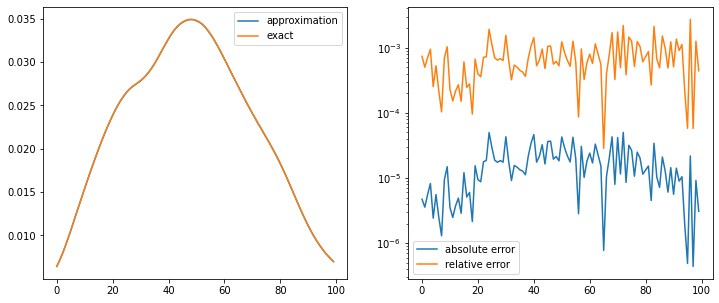

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(data, label = "approximation")
axs[0].plot(data_exact, label="exact")

axs[1].semilogy(np.abs(data-data_exact), label = "absolute error")
axs[1].semilogy(np.abs(data-data_exact)/np.abs(data), label = "relative error")

axs[0].legend()
axs[1].legend()

For our example here the error is $\approx 1e-5$, or just under 1%. That's ok I guess. If the error needs to be smaller, we can always refine the discretization in the memory mesh.

## Derivatives

Another advantage of storing measuremnts in memory is that we can
- a) do the same with the derivatives
- b) or use FEniCS to compute the derivatives of the measurements

Let's look at option b first and see how much error that introduces.

In [14]:
tStart = time.time()
deriv_exact = drone.d_measurement_d_position(flight=flight, state=state)
print("time to compute derivative: ", time.time()-tStart, "s.")

time to compute derivative:  9.537006855010986 s.


**Welcome back!**
I ran a bit out of steam here. For stationary measurements everything works great. The code at baseline is somewhat faster than I remember it, but it might just be that I've decreased the resolution.
Next steps:
- bring to work with time-dependent PDE
- do something with the derivatives

About the derivatives: I'm not sure about option b. The idea is good, but to get FEniCS to compute the derivatives, we need to call the method every time and for all nodes. It's not like for the state where it never changes. In the memory function, we are constantly adding new data, so we need to update the derivative as we go along.

Option a has the problem that if we want to be consistent with the discretization of our approximation on the memory mesh, then we need the derivatives to be piecewise constant on each cell. The strategy we are using right now where we are evaluating on nodes would therefore mess everything up.